In [27]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import os 
from matplotlib.patches import Polygon, FancyArrowPatch    # 用于画箭头的 ， 虽然没用到
from shapely.geometry import Polygon as ShapelyPolygon     # 用于确定多边形中心点位置
# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [28]:
"""
# 考虑了：
#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  
#     面积: 大于4e4 km^2
#     椭圆: 主轴长>100km 且 离心率大于0.4 

# 注意：
#     对单个时间的没有做融合， 因为取出的是外轮廓  
#     覆盖面积还需要再想想， 也就是 split 和 merge
#     椭圆和对应的长轴没有画在图上 , 最后最好把轮廓也画上这样方便比较

"""

'\n# 考虑了：\n#     亮温: Tb < 241K, 且有 Tb<225K  , 识别的是 241K  \n#     面积: 大于4e4 km^2\n#     椭圆: 主轴长>100km 且 离心率大于0.4 \n# \n#     没有做融合   \n#     覆盖面积还需要再想想， 也就是 split 和 merge\n    \n'

In [29]:
""" 
获取的数据：
    亮温： tbdata 
    经度： lon 
    纬度： lat 
"""
dir_pth = r"./data/"
all_datafiles_pth_list = os.listdir(dir_pth)
init_data_list  = []
tb_data_list = []
for i_file_pth in all_datafiles_pth_list:
    print(dir_pth+i_file_pth)
    i_file_data = xr.open_dataset(dir_pth+i_file_pth)
    # 处理单个文件数据 
    # i_file_data  =  i_file_data.sel(lat = slice(-10, 30), lon = slice(90, 180)  )  
    i_file_data  =  i_file_data.sel(lat = slice(-60, 60), lon = slice(-180, 180)  )  

    tbdata = i_file_data.irwin_cdr[0].to_numpy()   # 由于获取的数据是（1，lon, lat) 所有需转换成（lon, lat)， 且为numpy格式

    # 保存的数据
    init_data_list.append(i_file_data)    
    tb_data_list.append(tbdata)

lon = i_file_data.lon    # 每个文件的lon, lat 都一样，此处取第一个文件的lon, lat
lat = i_file_data.lat   


./data/GRIDSAT-B1.2023.07.23.03.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.06.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.09.v02r01.nc


# 连续区域识别 

## 找出需要的亮温区对应轮廓

In [30]:
# 找边界
def get_outline_contour(tb): 
    """
    tb: 亮温数据，  二维numpy数组
    return: 
        
    """
    # 找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # # 使用形态学膨胀操作扩展冷云区域、冷云核心，   也就是把边缘弄得精细一些。   
    # kernel = np.ones((1,1), np.uint8)  
    # cold_cores = cv2.dilate(cold_cores, kernel, iterations= 1)
    # cold_regions = cv2.dilate(cold_regions, kernel, iterations= 1)

    #按照 冷区 获取轮廓
    
    contours_cold_cores, _ = cv2.findContours(cold_cores, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_cold_regions, _ = cv2.findContours(cold_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 准备一个掩膜用于保存需要保留的cold_regions轮廓
    Tb_mask = np.zeros_like(cold_regions)
    for region_contour in contours_cold_regions:
        for core_contour in contours_cold_cores:
            # 检查cold_cores的轮廓是否在cold_regions的轮廓内部    ， # core_contour[0][0]是np array, 不是list
            dist = cv2.pointPolygonTest(region_contour, tuple(core_contour[0][0].tolist()), measureDist=False)
            if dist >= 0:  # 如果core_contour的一个点在region_contour内（包括边界）
                # 绘制这个cold_regions轮廓到掩膜上
                cv2.drawContours(Tb_mask, [region_contour], -1, color=255, thickness=cv2.FILLED)
                break  # 一旦找到匹配，跳出循环检查下一个cold_regions轮廓
    return Tb_mask
    # filtered_contours, _ = cv2.findContours(Tb_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return Tb_mask, filtered_contours  # 返回掩膜和轮廓列


## 判断面积


In [31]:
def judge_area(otline_contour, real_area_threshold= 4e4):
    jg_pixel_threshold = real_area_threshold/(8*8)   #  1 pixel = 8*8 km^2 
    filtered_contours, _ = cv2.findContours(otline_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pts_list = [cnt for cnt in filtered_contours if cv2.contourArea(cnt) > jg_pixel_threshold]
    return contours_pts_list

## 椭圆

In [32]:
# 拟合长轴
def judge_ellipse(otline_pts_list):
    mch_elip_area_list  = []
    count_unfit_elip = 0
    for cnt in otline_pts_list:
        if len(cnt) >= 5: # 确保有足够数量的点来拟合椭圆
            ellipse = cv2.fitEllipse(cnt)
            
            # 判断主长轴、离心率
            major_axis_legth = max(ellipse[1][0], ellipse[1][1])
            minor_axis_legth = min(ellipse[1][0], ellipse[1][1])
            # 离心率计算
            ecc = np.sqrt(1 - (minor_axis_legth / major_axis_legth)**2)
            if (major_axis_legth > (100/8))& (ecc > 0.4):    # 1 pixel = 8km
                mch_elip_area_list.append(cnt)
        else:
            count_unfit_elip += 1
            print("统计无法拟合椭圆的轮廓数：", count_unfit_elip)
    return  mch_elip_area_list


## 轮廓点转换为经纬度(待使用)

In [33]:
def outline2lonlat(otline_pts_list, lon , lat ):
    lonlat_pts_list = []
    for i_outline in otline_pts_list:
        # print(i_outline.squeeze().shape)
        # print("print(print(i_outline.squeeze()))")
        # print(print(i_outline.squeeze()))
        # print("==================================")
        
        i_new_list = []
        for i_lonlat in i_outline.squeeze():   #  [x  y] 的一个点  
            i_lon = lon[i_lonlat[0]].item()
            i_lat = lat[i_lonlat[1]].item()
            i_new_list.append([i_lon, i_lat]) 
        lonlat_pts_list.append(i_new_list)
    return lonlat_pts_list

## 将轮廓点转化为对应的掩码和真实数据

In [34]:
def get_dataAndmask(outline_mask, matched_outline_list, initdata):
    result_mask = np.zeros_like(outline_mask)   
    for i_outline_3Dpts in matched_outline_list:
        cv2.drawContours(result_mask, [i_outline_3Dpts], -1, color=255, thickness=cv2.FILLED)
    data = np.where(result_mask, initdata, np.nan  )  # result_mask中的元素为0或者255，0也就是False, 所以mask可以作为掩码
    return  data , result_mask 

# 云的移动追踪

In [35]:
def calculate_overlap(contour1, contour2, shape):
    """
    计算两个轮廓之间的重叠比例（intersection / area of contour1）
    :param contour1: 轮廓1
    :param contour2: 轮廓2
    :param shape: 图像尺寸 (height, width)
    :return: overlap ratio
    """
    mask1 = np.zeros(shape, dtype=np.uint8)
    mask2 = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(mask1, [contour1], -1, color=1, thickness=cv2.FILLED)
    cv2.drawContours(mask2, [contour2], -1, color=1, thickness=cv2.FILLED)

    intersection = np.logical_and(mask1, mask2).sum()
    area1 = cv2.contourArea(contour1)
    return intersection / area1 if area1 > 0 else 0

In [36]:
def track_clouds(contours_list, img_shape):
    """
    :param contours_list: list[list[contours]]，每个元素是一帧中的多个轮廓
    :return: tracked_contours: 每个轮廓带有一个ID
    """
    tracked_contours = []  # 存储每帧的 (contour, id) 列表
    current_id = 0

    for i, frame_contours in enumerate(contours_list):
        current_tracked = []   
        if i == 0:
            # 第一帧所有轮廓都是新ID
            for cnt in frame_contours:
                current_tracked.append((cnt, current_id))
                current_id += 1
        else:
            prev_tracked = tracked_contours[i - 1]
            used_idx = set()

            for cnt in frame_contours:
                best_ratio = 0
                best_id = None

                for j, (prev_cnt, pid) in enumerate(prev_tracked): #  j 就是id 
                    if j in used_idx:
                        continue
                    overlap_ratio = calculate_overlap(prev_cnt, cnt, img_shape)
                    if overlap_ratio > best_ratio and overlap_ratio >= 0.5:
                        best_ratio = overlap_ratio
                        best_id = pid

                if best_id is not None:
                    used_idx.add(j)
                    current_tracked.append((cnt, best_id))
                else:
                    # 新云团
                    current_tracked.append((cnt, current_id))
                    current_id += 1

        tracked_contours.append(current_tracked)

    return tracked_contours  

In [37]:
# 获取不同时刻的完整轮廓
contours_list = []  # 存储每个时刻的轮廓列表
for tb in tb_data_list:
    outline_mask = get_outline_contour(tb)  # 和 tb单个文件的shape 一样
    match_area_list = judge_area(outline_mask)
    mch_area_elip_list   = judge_ellipse(match_area_list)
    contours_list.append(mch_area_elip_list)

# 开始追踪
tracked_contours  =  track_clouds(contours_list, tb_data_list[0].shape)

In [38]:

# 第一步：按ID分组，并记录每个ID在哪些时间帧中出现过
id_dict = {}
for t, frame in enumerate(tracked_contours):
    for contour, cid in frame:
        if cid not in id_dict:
            id_dict[cid] = []  # 初始化该ID的列表
        id_dict[cid].append({
            't': t,
            'contour': contour
        })

# 第二步：筛选出存在 ≥2 个时刻的云团，并以 {cid: {t: contour}} 的形式保存

t_dict = {}
for id in id_dict.keys():
    items = id_dict[id]
    if len(items) >= 2:
        for item in items:
            t = item['t']
            cnt = item['contour']
            if t not in t_dict:
                t_dict[t] = []
            t_dict[t].append({
                'id': id,
                'contour': cnt
            })

In [39]:
track_otlin_list = []
clean_otline_data = []
for i_t in t_dict.keys():
    i_t_track_otlin_list = []
    for i in range(len(t_dict[i_t])):
        cnt = t_dict[i_t][i]['contour']
        i_t_track_otlin_list.append(cnt)
    data , result_mask = get_dataAndmask(outline_mask, i_t_track_otlin_list, tb_data_list[0])
    # 保存数据
    clean_otline_data.append(data)
    track_otlin_list.append(i_t_track_otlin_list)


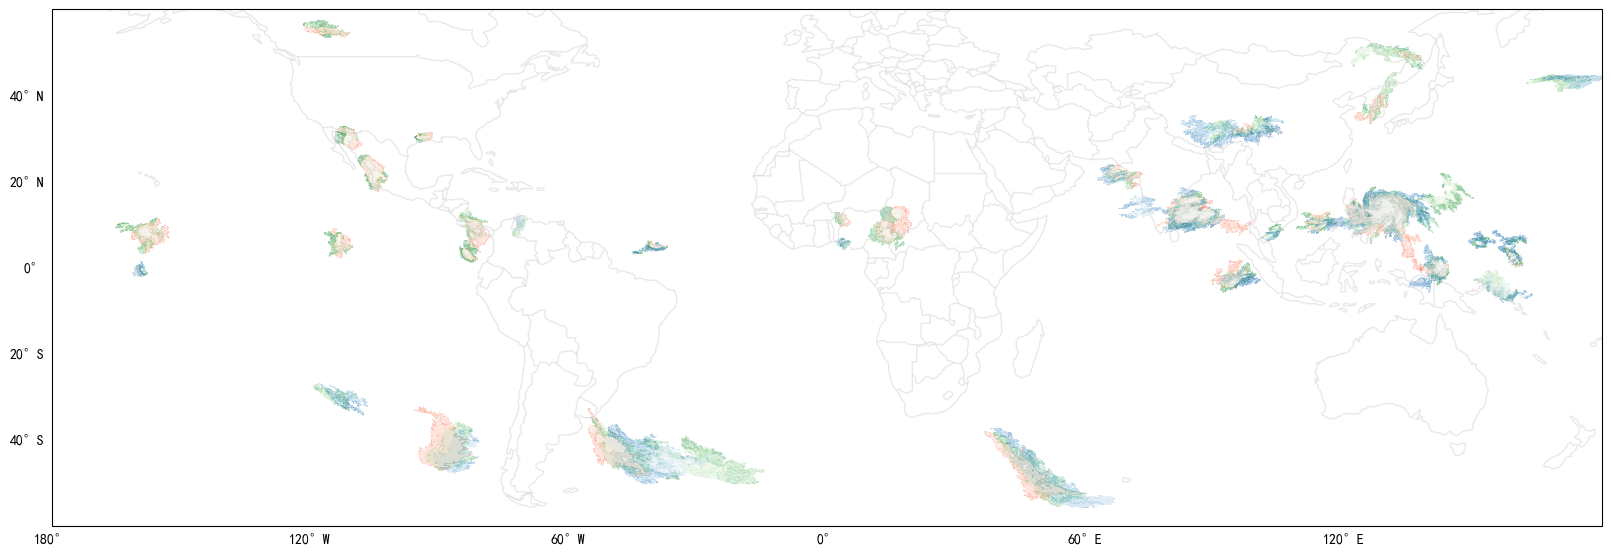

In [40]:
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

# cmap_list = ["binary", 'Blues', 'Reds']
cmaplist = [ 'Reds', 'Greens','Blues']

color_list = ['gray', 'darkblue', 'darkred']

for i_t in range(len(clean_otline_data)):
    ax.contourf(lon,lat , clean_otline_data[i_t ], 
                cmap=cmaplist[i_t], 
                alpha =  0.2,
                transform=ccrs.PlateCarree())

plt.show()

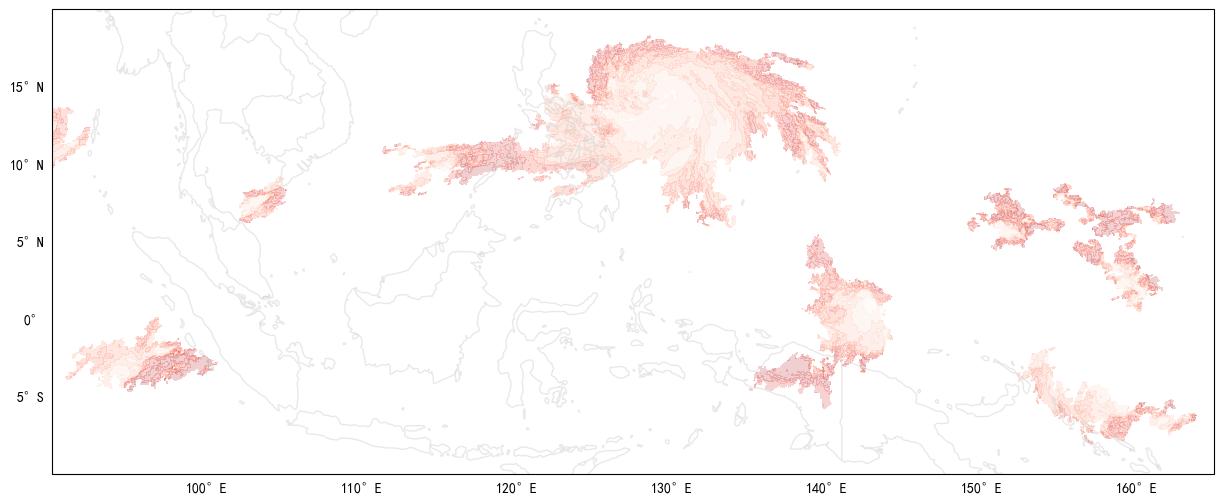

In [41]:
fig, ax = plt.subplots(figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

cmap_list = ["binary", 'Blues', 'Reds']
color_list = ['gray', 'darkblue', 'darkred']

cmaplist = ['binary', 'Blues', 'Reds']
ax.contourf(lon,lat , clean_otline_data[2], 
            cmap=cmaplist[2], 
            alpha =  0.2,
            transform=ccrs.PlateCarree())

plt.show()

In [42]:

# for i_t in range(len(track_otlin_list)):
#     cnts = track_otlin_list[i_t]
#     for i_cnt in cnts:
#         mask1 = np.zeros(tb_data_list[0].shape, dtype=np.uint8)
#         cv2.drawContours(mask1, [i_cnt], -1, color=1, thickness=cv2.FILLED)
    

In [43]:
# 使用不同的函数  
outline_mask = get_outline_contour(tb_data_list[0])  # 和 tb单个文件的shape 一样
match_area_list = judge_area(outline_mask)
mch_area_elip_list   = judge_ellipse(match_area_list)

In [44]:
# 接着使用不同的函数 
# lonlat_pts_list = outline2lonlat(mch_area_elip_list, lon , lat )
data ,  datamask = get_dataAndmask(outline_mask, mch_area_elip_list, tb_data_list[0])



In [45]:
print(outline_mask.shape)
print(tb_data_list[0].shape)
print(outline_mask[outline_mask != 0])
print("print(len(match_area_list))")
print(len(match_area_list))
print("print(len(mch_area_elip_list))")
print(len(mch_area_elip_list))

print("print(lonlat_pts_list)")
# print(lonlat_pts_list)


(1715, 5143)
(1715, 5143)
[255 255 255 ... 255 255 255]
print(len(match_area_list))
74
print(len(mch_area_elip_list))
74
print(lonlat_pts_list)


In [46]:
# 在地图上绘制出椭圆
_, binary_outline_mask = cv2.threshold(outline_mask, 127, 255, cv2.THRESH_BINARY)

# 将二值图像转换为三通道图像以便画彩色椭圆
binary_outline_mask_color = cv2.cvtColor(binary_outline_mask, cv2.COLOR_GRAY2BGR)

# 在原图上绘制椭圆
for cnt in mch_area_elip_list:
    if len(cnt) >= 5:  # 确保有足够的点来拟合椭圆
        ellipse = cv2.fitEllipse(cnt)
        cv2.ellipse(binary_outline_mask_color, ellipse, color=(0, 0, 255), thickness=2)  # 使用红色绘制椭圆


# 显示/保存结果
cv2.imshow("Ellipses on Binary Outline Mask", binary_outline_mask_color)
cv2.waitKey(0)
cv2.destroyAllWindows()


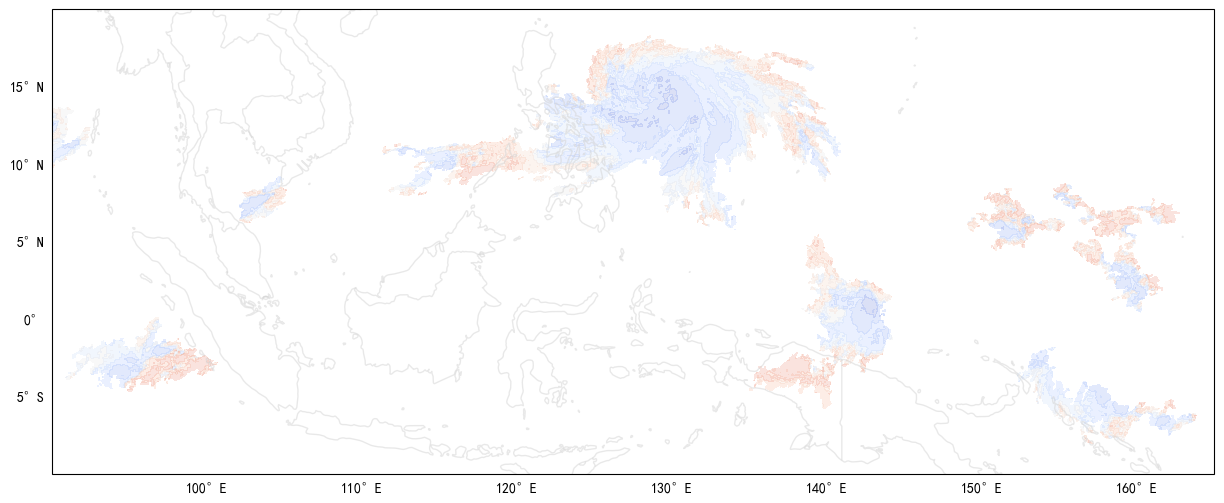

In [47]:
fig, ax = plt.subplots(figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

cmap_list = ["binary", 'Blues', 'Reds']
color_list = ['gray', 'darkblue', 'darkred']

data = np.where(result_mask, tb_data_list[0], np.nan)
ax.contourf(lon,lat , data, 
            cmap='coolwarm', 
            alpha =  0.2,
            transform=ccrs.PlateCarree())

plt.show()